# Low & Medium Risk

## Package

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve,f1_score, plot_confusion_matrix,plot_roc_curve
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

## Load Data

In [2]:
df = pd.read_csv('../data/cleaned_train.csv')
df = df.drop('qid',axis=1)
# proportion of target
df.target.value_counts(dropna=False)

0    1225312
1      80810
Name: target, dtype: int64

In [3]:
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /Users/billy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/billy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/billy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Feature Engineering

### Some Statistical Features

In [4]:
df['length']=df['question_text'].apply(len)
df['capital']=df['question_text'].apply(lambda text: sum([1 for c in text if c.isupper()]))
df['capital_to_length']=df['capital'] / df['length']
df['word_count'] = df['question_text'].str.count('\S+')
df['word_to_length'] = df['length'] / df['word_count']

In [5]:
#split train and Validation data
X_train, X_test, y_train, y_test = train_test_split(
     df.drop('target',axis=1), df['target'], test_size=0.33, random_state=2021)

In [6]:
X_train_text = X_train['question_text']
X_train_stat_feature = np.round(X_train.drop('question_text',axis=1).values,3)
X_test_text = X_test['question_text']
X_test_stat_feature = np.round(X_test.drop('question_text',axis=1).values,3)

### TF_IDF features

In [7]:
#Lokenizer with WordNet Lemma
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        self.tokenizer =  RegexpTokenizer(r'\w+')
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in self.tokenizer.tokenize(doc)]

In [8]:
cv = CountVectorizer(stop_words=stop_words,max_features=1000,tokenizer=LemmaTokenizer())
tfidf = TfidfVectorizer(max_features=1000,stop_words=stop_words, tokenizer= LemmaTokenizer())

In [9]:
tfidf.fit(df['question_text'])
X_train_tfidf = tfidf.transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

/Users/billy/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/Users/billy/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [10]:
from scipy.sparse import hstack
X_train = hstack((X_train_tfidf, X_train_stat_feature))
X_test = hstack((X_test_tfidf,X_test_stat_feature))

## EDA

In [11]:
eda_df = df.copy()
df.head()

,question_text,target,length,capital,capital_to_length,word_count,word_to_length
0,How did Quebec nationalists see their province...,0,74,2,0.027027,15,4.933333
1,"Do you have an adopted dog , how would you enc...",0,83,1,0.012048,18,4.611111
2,Why does velocity affect time ? Does velocity ...,0,69,2,0.028986,12,5.750000
3,How did Otto von Guericke used the Magdeburg h...,0,58,4,0.068966,10,5.800000
4,Can I convert montra helicon D to a mountain b...,0,78,3,0.038462,16,4.875000


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
sns.set(font_scale=1.5)
# warnings.filterwarnings('ignore')

/Users/billy/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


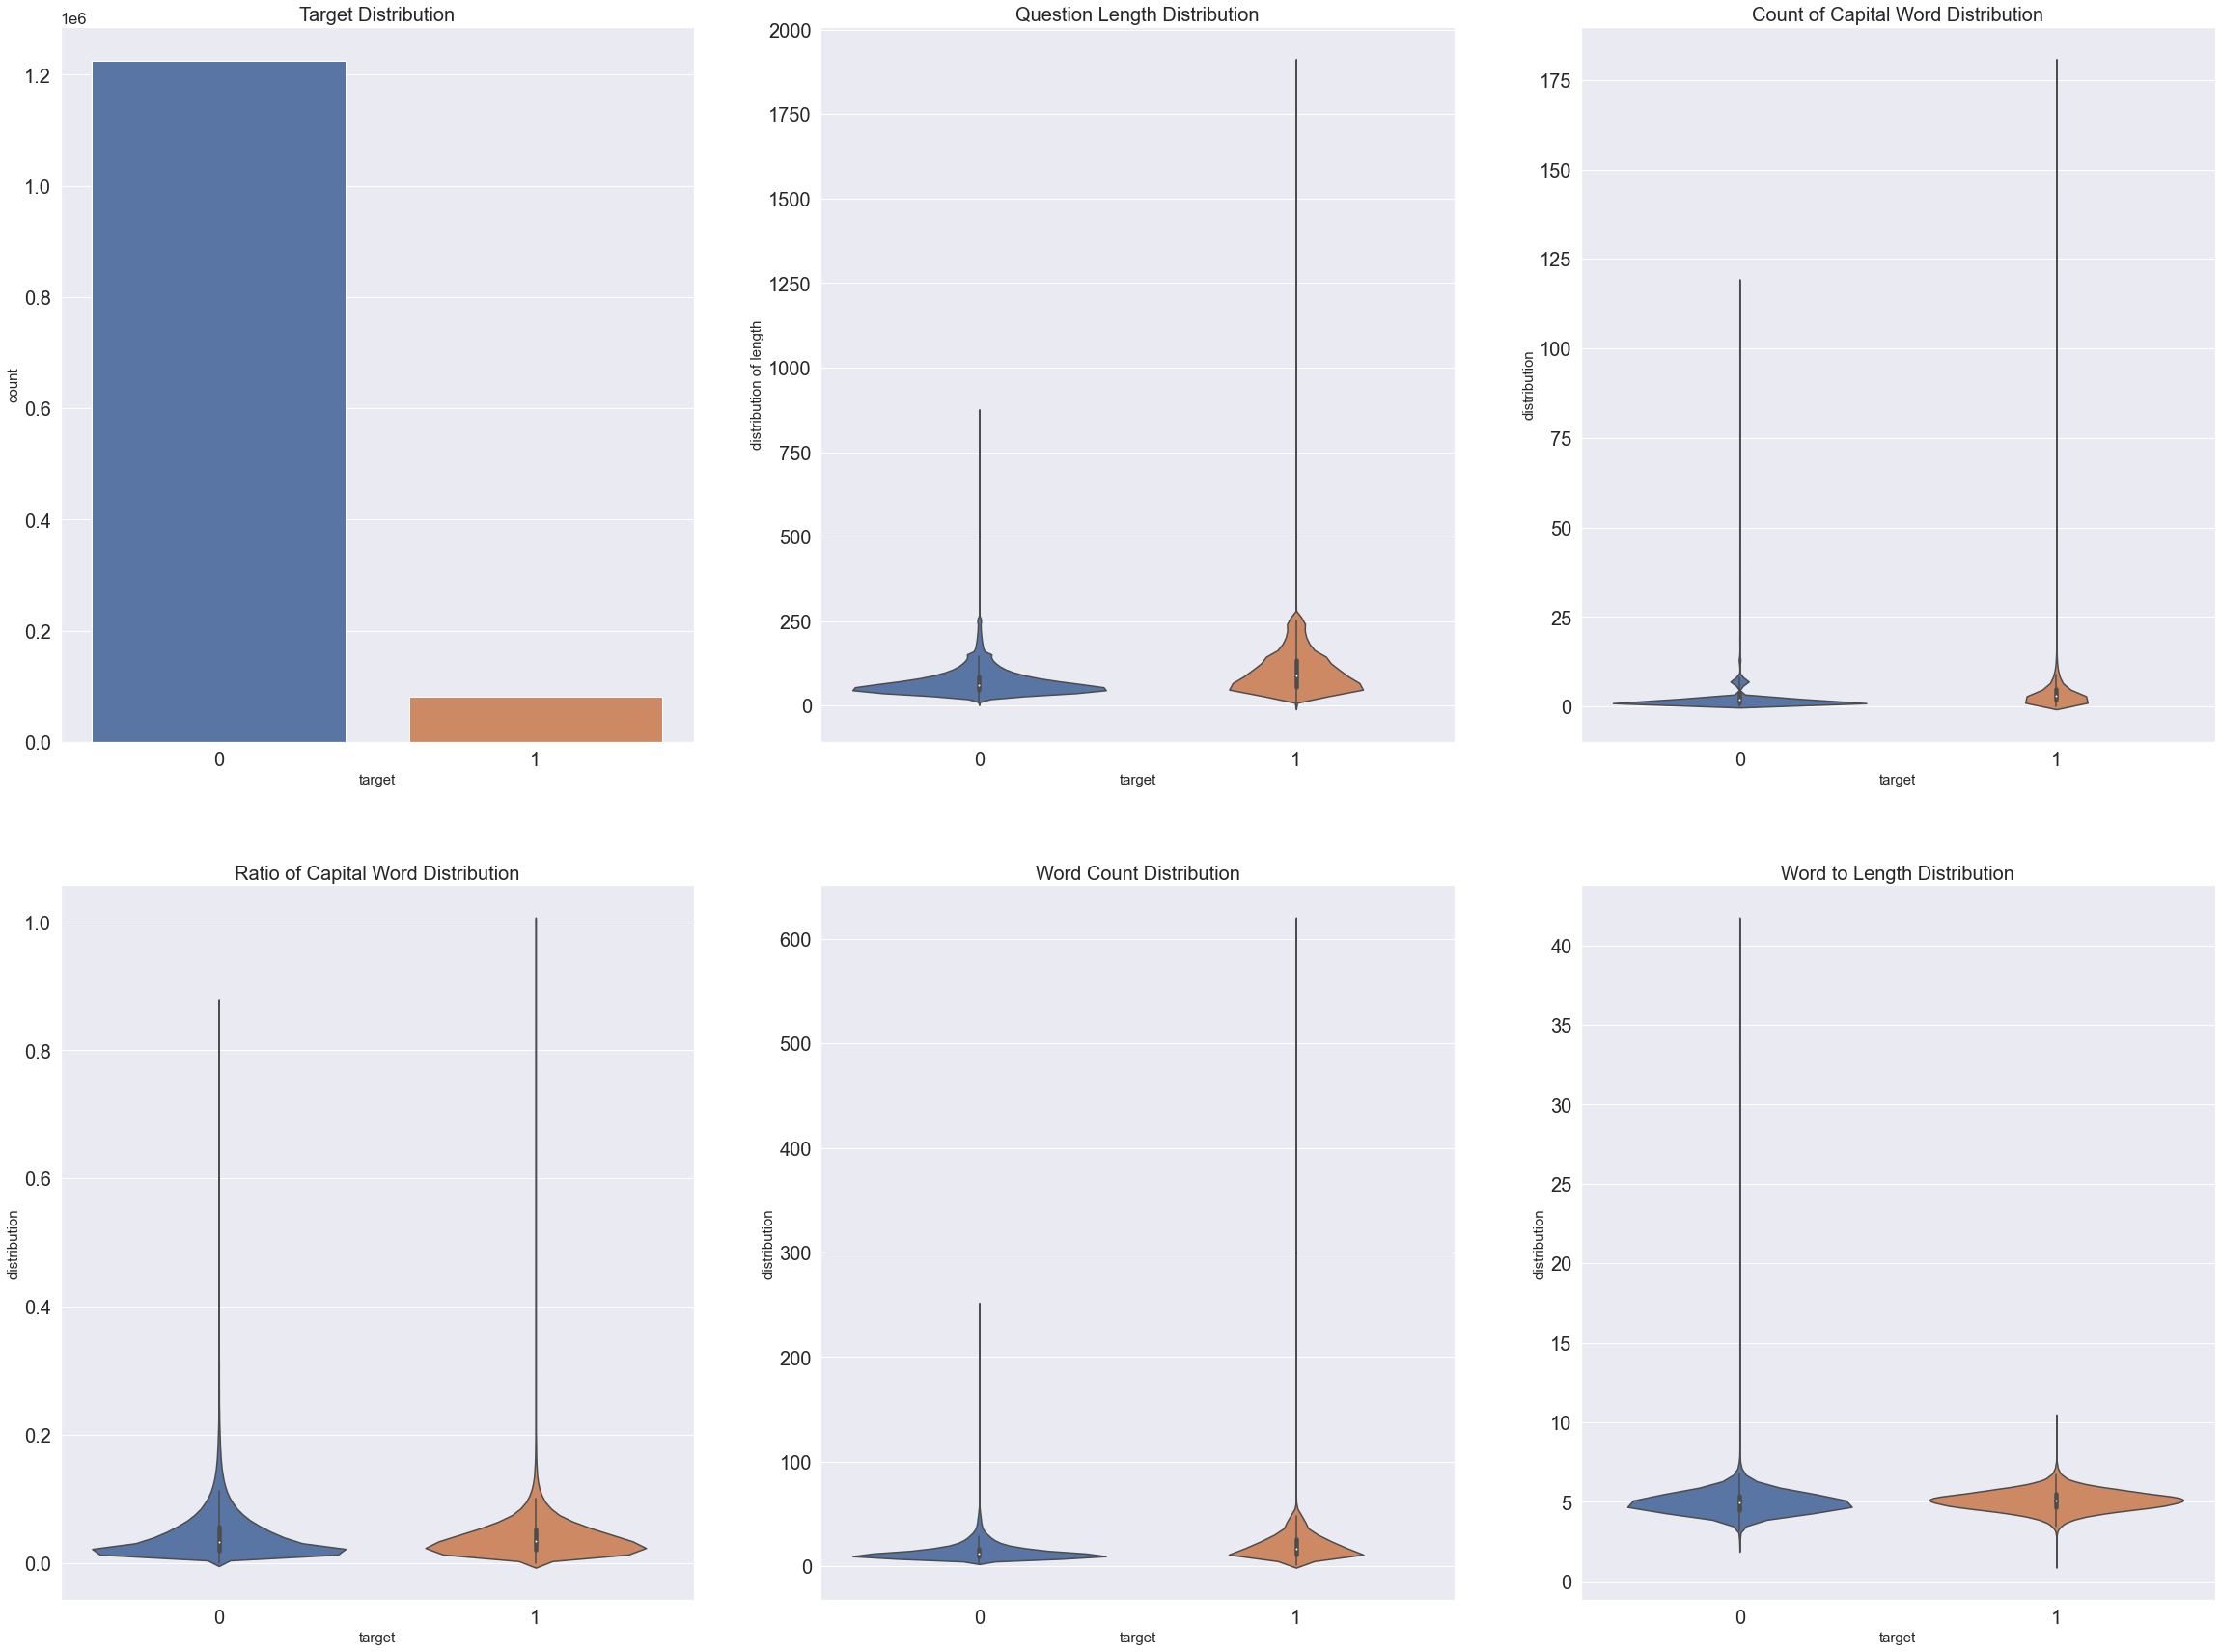

In [62]:
figure,ax = plt.subplots(2,3,figsize = (40,30))

plt.subplot(231)
sns.countplot(eda_df['target'])
plt.title('Target Distribution',fontdict={'weight':'normal','size': 20}) 
plt.xlabel('target', fontdict={'weight': 'normal', 'size': 15})
plt.ylabel('count', fontdict={'weight': 'normal', 'size': 15})
plt.tick_params(labelsize=20)

plt.subplot(232)
sns.violinplot(x='target', y='length', data=eda_df)
plt.title('Question Length Distribution',fontdict={'weight':'normal','size': 20}) 
plt.xlabel('target', fontdict={'weight': 'normal', 'size': 15})
plt.ylabel('distribution of length', fontdict={'weight': 'normal', 'size': 15})
plt.tick_params(labelsize=20)
plt.rcParams.update({'font.size': 30})

plt.subplot(233)
sns.violinplot(x='target', y='capital', data=eda_df)
plt.title('Count of Capital Word Distribution',fontdict={'weight':'normal','size': 20}) 
plt.xlabel('target', fontdict={'weight': 'normal', 'size': 15})
plt.ylabel('distribution', fontdict={'weight': 'normal', 'size': 15})
plt.tick_params(labelsize=20)
plt.rcParams.update({'font.size': 30})

plt.subplot(234)
sns.violinplot(x='target', y='capital_to_length', data=eda_df)
plt.title('Ratio of Capital Word Distribution',fontdict={'weight':'normal','size': 20}) 
plt.xlabel('target', fontdict={'weight': 'normal', 'size': 15})
plt.ylabel('distribution', fontdict={'weight': 'normal', 'size': 15})
plt.tick_params(labelsize=20)
plt.rcParams.update({'font.size': 30})

plt.subplot(235)
sns.violinplot(x='target', y='word_count', data=eda_df)
plt.title('Word Count Distribution',fontdict={'weight':'normal','size': 20}) 
plt.xlabel('target', fontdict={'weight': 'normal', 'size': 15})
plt.ylabel('distribution', fontdict={'weight': 'normal', 'size': 15})
plt.tick_params(labelsize=20)
plt.rcParams.update({'font.size': 30})

plt.subplot(236)
sns.violinplot(x='target', y='word_to_length', data=eda_df)
plt.title('Word to Length Distribution',fontdict={'weight':'normal','size': 20}) 
plt.xlabel('target', fontdict={'weight': 'normal', 'size': 15})
plt.ylabel('distribution', fontdict={'weight': 'normal', 'size': 15})
plt.tick_params(labelsize=20)
plt.rcParams.update({'font.size': 30})

### text transformation

In [14]:
# lower
def lower_text(s:str)->str:
    return s.lower()

# remove punctuation and number
def remove_punctuation(s:str)->str:
    return s.replace('[^\w\s0-9]','')
    
# remove stopwords
def remove_stopword(s:str)->str:
    return " ".join(w for w in s.split() if w not in stop_words and len(w)>2)

# stemming
from nltk.stem import SnowballStemmer
ss=SnowballStemmer('english')
def stemming(s:str)->str:
    try:
        return " ".join(ss.stem(x) for x in s.split())
    except:
        return ""
    
# lemmatisation
from nltk.stem import WordNetLemmatizer
wl = WordNetLemmatizer()
def lemmatisation(s:str)->str:
    try:
        return " ".join(wl.lemmatize(w,'v') for w in s.split())
    except:
        return ""

In [15]:
eda_df['question_text'] = eda_df['question_text'] \
                    .apply(lower_text) \
                    .apply(remove_punctuation) \
                    .apply(remove_stopword) \
                    .apply(lemmatisation)
#                     .apply(stemming) \ 

In [16]:
eda_df

,question_text,target,length,capital,capital_to_length,word_count,word_to_length
0,quebec nationalists see province nation 1960,0,74,2,0.027027,15,4.933333
1,adopt dog would encourage people adopt shop,0,83,1,0.012048,18,4.611111
2,velocity affect time velocity affect space geo...,0,69,2,0.028986,12,5.750000
3,otto von guericke use magdeburg hemispheres,0,58,4,0.068966,10,5.800000
4,convert montra helicon mountain bike change tyres,0,78,3,0.038462,16,4.875000
...,...,...,...,...,...,...,...
1306117,technical skills need computer science undergrad,0,96,1,0.010417,20,4.800000
1306118,ece good job prospect usa like india job present,0,92,12,0.130435,20,4.600000
1306119,foam insulation toxic,0,26,1,0.038462,5,5.200000
1306120,one start research project base biochemistry l...,0,72,3,0.041667,14,5.142857


### wordcloud

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

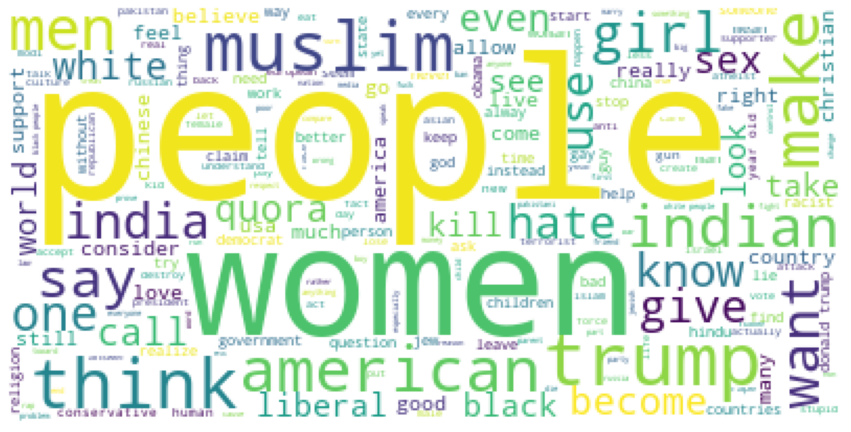

In [22]:
wc=WordCloud(background_color='white')
wc.generate("".join(eda_df[eda_df.target==1].question_text))
plt.figure(1,figsize=(15,15))
plt.axis('off')
plt.imshow(wc)
plt.show()

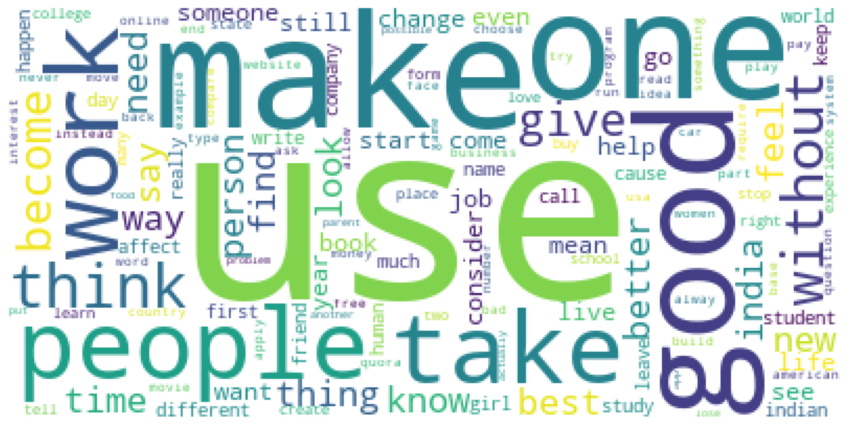

In [23]:
wc=WordCloud(background_color='white')
wc.generate("".join(eda_df[eda_df.target==0].question_text))
plt.figure(1,figsize=(15,15))
plt.axis('off')
plt.imshow(wc)
plt.show()

### Topic Model

In [24]:
from sklearn.decomposition import LatentDirichletAllocation,TruncatedSVD

def get_topics(components, feature_names, n=10):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx))
        print([(feature_names[i], topic[i])
                        for i in topic.argsort()[:-n - 1:-1]])

In [25]:
tfidf_v = TfidfVectorizer(min_df=20,max_df=0.8,sublinear_tf=True,ngram_range={1,2})
#matrixTFIDF= tfidf_v.fit_transform(train.question_text)
matrixTFIDF= tfidf_v.fit_transform(eda_df[eda_df.target==1].question_text)
print(matrixTFIDF.shape)

(80810, 5467)


In [26]:
lda = LatentDirichletAllocation(n_components=10,random_state=2021,max_iter=10)
lda.fit_transform(matrixTFIDF)

array([[0.02795592, 0.02796398, 0.02795705, ..., 0.02795781, 0.45252641,
        0.02795899],
       [0.02979403, 0.02978546, 0.73188199, ..., 0.02979309, 0.02979197,
        0.02980171],
       [0.02543207, 0.0254295 , 0.0254398 , ..., 0.02542947, 0.02544303,
        0.77108282],
       ...,
       [0.04147144, 0.041452  , 0.04145325, ..., 0.04145357, 0.04146163,
        0.0414519 ],
       [0.02040335, 0.02040609, 0.02040795, ..., 0.02040346, 0.81634734,
        0.02040446],
       [0.04210132, 0.6211396 , 0.04210484, ..., 0.04209101, 0.04209283,
        0.04209212]])

In [27]:
def get_topics(components, feature_names, n=15):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx))
        print([(feature_names[i], topic[i])
                        for i in topic.argsort()[:-n - 1:-1]])

In [28]:
get_topics(lda.components_,tfidf_v.get_feature_names(),n=10)

Topic 0:
[('women', 806.1858164490303), ('men', 705.8559925150159), ('girls', 521.3508753321972), ('like', 338.16689893255176), ('white', 320.32338293854804), ('guy', 304.8696861851866), ('people', 260.7512083031664), ('indian', 250.18408114661676), ('black', 247.50076898155652), ('look', 232.29580189230035)]
Topic 1:
[('muslims', 659.8730234003876), ('old', 283.88213453786256), ('muslim', 272.4238648949694), ('year', 236.8754033945659), ('islam', 235.004506784981), ('hindus', 208.32959115143368), ('year old', 203.9413777556165), ('india', 198.06429366032873), ('israel', 186.82550830342228), ('hate', 159.59213597388683)]
Topic 2:
[('people', 399.16766954476776), ('black', 371.53787937766043), ('white', 337.2693949844525), ('americans', 233.61764481362425), ('feminism', 203.6282992847894), ('black people', 199.1340136167824), ('white people', 172.98571697046586), ('feminism supporters', 153.6586955110696), ('wear', 150.39045182271204), ('supporters', 149.71533923510316)]
Topic 3:
[('tru

## Text Classification (Naive Bayes)

### Use tf-idf only

In [29]:
nb_classifier = MultinomialNB()
# hyperparameter tuning
parameters = {'alpha':[0.001,0.01,0.1,1,10,100,1000]}
grid_search = GridSearchCV(nb_classifier, parameters,scoring='roc_auc')
grid_search.fit(X_train_tfidf, y_train)

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='roc_auc')

In [30]:
print('best parameter is', grid_search.best_params_)
print('best score is', grid_search.best_score_)

best parameter is {'alpha': 10}
best score is 0.8855933836992513


In [63]:
#metrics report
predict_proba_test = grid_search.predict_proba(X_test_tfidf)[:,1]
predict_test = grid_search.predict(X_test_tfidf)

accuracy = accuracy_score(y_true=y_test, y_pred=predict_test)
auc = roc_auc_score(y_true=y_test,y_score=predict_proba_test)

print('accuracy on the test set: {:.3f} \nauc on the test set: {:.3f}'.format(accuracy, auc))

plt.rcParams.update(plt.rcParamsDefault)

accuracy on the test set: 0.941 
auc on the test set: 0.885


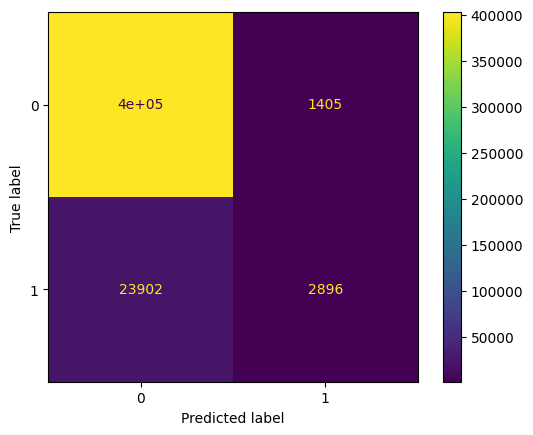

In [64]:
plot_confusion_matrix(grid_search, X_test_tfidf,y_test)

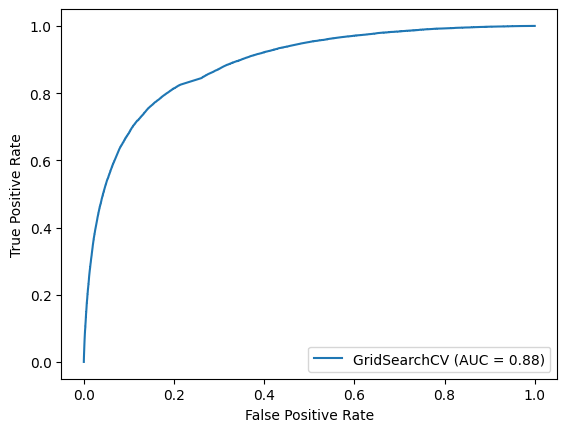

In [73]:
plot_roc_curve(grid_search,X_test_tfidf,y_test)

### add statistical features

In [66]:
nb_classifier = MultinomialNB()
parameters = {'alpha':[0.001,0.01,0.1,1,10,100,1000]}
grid_search_2 = GridSearchCV(nb_classifier, parameters,scoring='roc_auc')

In [67]:
grid_search_2.fit(X_train, y_train)

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='roc_auc')

In [68]:
print('best parameter is', grid_search_2.best_params_)
print('best score is', grid_search_2.best_score_)

best parameter is {'alpha': 0.001}
best score is 0.8887804347053935


In [69]:
predict_proba_test = grid_search_2.predict_proba(X_test)[:,1]
predict_test = grid_search_2.predict(X_test)

accuracy = accuracy_score(y_true=y_test, y_pred=predict_test)
auc = roc_auc_score(y_true=y_test,y_score=predict_proba_test)

print('accuracy on the test set: {:.3f} \nauc on the test set: {:.3f}'.format(accuracy, auc))

accuracy on the test set: 0.940 
auc on the test set: 0.889


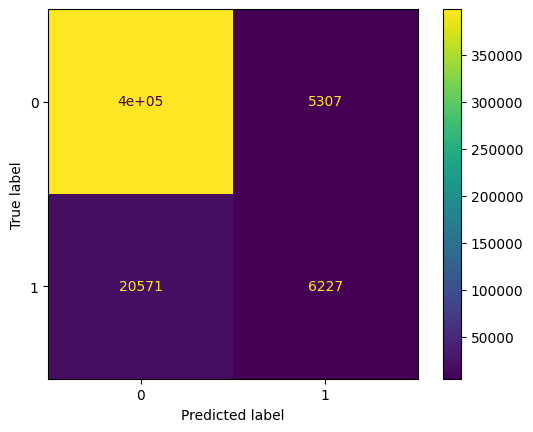

In [70]:
plot_confusion_matrix(grid_search_2, X_test,y_test)

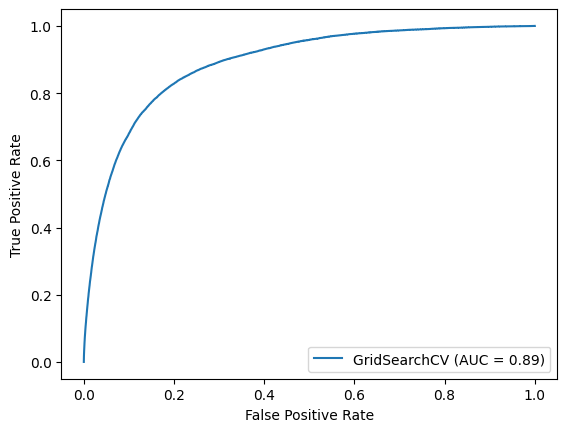

In [71]:
plot_roc_curve(grid_search_2,X_test,y_test)